In [1]:
import rdflib
from rdflib import Graph, URIRef, RDF, RDFS, OWL
import networkx as nx
from itertools import product

# =============================================================================
# Step 1: Load Ontologies and Mappings
# =============================================================================
src_onto_path = "src_onto_test.owl"
tgt_onto_path = "tgt_onto_test.owl"
mappings_path = "mappings.owl" # from LogMap

src_graph = Graph()
src_graph.parse(src_onto_path, format="xml")

tgt_graph = Graph()
tgt_graph.parse(tgt_onto_path, format="xml")

mappings_graph = Graph()
mappings_graph.parse(mappings_path, format="xml")

# =============================================================================
# Step 2: Build Association Graphs with NetworkX
# =============================================================================
def build_association_graph(ontology_graph):
    """
    Build a NetworkX DiGraph from an ontology graph.
    
    - Nodes: For each OWL.Class, add a node with attribute 'concept' = class URI (string) and is_attribute=False.
    - Edges (Object Properties): For each OWL.ObjectProperty, for each domain and range, 
      if both appear as classes, add an edge from domain to range with label = property URI.
    - Nodes & Edges (Datatype Properties): For each OWL.DatatypeProperty, for each domain,
      add a node for the property itself (using the property URI as identifier) with attribute 'attribute_property'
      = property URI and is_attribute=True, then add an edge from the domain to this property node with label = property URI.
    """
    G = nx.DiGraph()
    
    # Add all classes as nodes
    for cls in ontology_graph.subjects(RDF.type, OWL.Class):
        G.add_node(cls, concept=str(cls).strip(), is_attribute=False)
    
    # Process object properties
    for prop in ontology_graph.subjects(RDF.type, OWL.ObjectProperty):
        for domain in ontology_graph.objects(prop, RDFS.domain):
            for rng in ontology_graph.objects(prop, RDFS.range):
                # Only add if both domain and range are in our graph (i.e. are defined classes)
                if domain in G and rng in G:
                    G.add_edge(domain, rng, label=str(prop).strip())
    
    # Process datatype properties
    for prop in ontology_graph.subjects(RDF.type, OWL.DatatypeProperty):
        for domain in ontology_graph.objects(prop, RDFS.domain):
            # Use the property URI itself as the attribute node
            attr_node = prop  # property itself
            # Add the attribute node if not present
            if attr_node not in G:
                G.add_node(attr_node, attribute_property=str(prop).strip(), is_attribute=True)
            # Add edge from the domain to the attribute node if domain exists
            if domain in G:
                G.add_edge(domain, attr_node, label=str(prop).strip())
    return G

# Build NetworkX graphs from the source and target ontologies.
source_nx_graph = build_association_graph(src_graph)
target_nx_graph = build_association_graph(tgt_graph)

# =============================================================================
# Debug: Print Nodes and Edges of the Association Graphs
# =============================================================================
print("\n=== Source Association Graph ===")
for n, data in source_nx_graph.nodes(data=True):
    print(f"Node: {n}, Data: {data}")
print("\nEdges in Source Graph:")
for u, v, data in source_nx_graph.edges(data=True):
    print(f"{u} -- {data['label']} --> {v}")

print("\n=== Target Association Graph ===")
for n, data in target_nx_graph.nodes(data=True):
    print(f"Node: {n}, Data: {data}")
print("\nEdges in Target Graph:")
for u, v, data in target_nx_graph.edges(data=True):
    print(f"{u} -- {data['label']} --> {v}")

# =============================================================================
# Step 3: Parse Mappings from mappings.owl
# =============================================================================
def parse_mappings(mappings_graph):
    """
    Parse mappings.owl and extract Concept2Concept correspondences.
    Returns a list of dictionaries.
    """
    correspondences = []
    for src_class, _, tgt_class in mappings_graph.triples((None, OWL.equivalentClass, None)):
        correspondences.append({
            "source": str(src_class).strip(), 
            "target": str(tgt_class).strip(), 
            "type": "Concept2Concept"
        })
        # Also add the inverse mapping
        correspondences.append({
            "source": str(tgt_class).strip(), 
            "target": str(src_class).strip(), 
            "type": "Concept2Concept"
        })
    # If needed, add Attr2Attr parsing here.
    return correspondences

correspondences = parse_mappings(mappings_graph)
print("\nParsed Correspondences:")
for c in correspondences:
    print(c)

# =============================================================================
# Step 4: Generate Candidate Mappings (Nodes and Edges)
# =============================================================================
def get_candidate_source_nodes(G, is_attribute):
    """Return all nodes in G with attribute 'is_attribute' equal to the given flag."""
    return [n for n, data in G.nodes(data=True) if data.get("is_attribute", False) == is_attribute]

def generate_node_candidate_mappings(source_graph, target_graph, correspondences):
    """
    For each target node in target_graph, generate candidate source nodes.
    For concept nodes, if an explicit Concept2Concept mapping exists (matching target's 'concept'),
    restrict candidate set; else use all source concept nodes.
    For attribute nodes, do similarly.
    Always add epsilon (None).
    Returns a dictionary mapping target nodes to lists of candidate source nodes.
    """
    mapping_options = {}
    source_concepts = get_candidate_source_nodes(source_graph, is_attribute=False)
    source_attributes = get_candidate_source_nodes(source_graph, is_attribute=True)
    
    for t_node, t_data in target_graph.nodes(data=True):
        if not t_data.get("is_attribute", False):
            explicit = [c for c in correspondences if c["type"] == "Concept2Concept" and c["target"] == t_data.get("concept")]
            if explicit:
                candidates = []
                for mapping in explicit:
                    expected = mapping["source"].strip().lower()
                    for s_node in source_concepts:
                        s_val = source_graph.nodes[s_node].get("concept", "").strip().lower()
                        if s_val == expected:
                            candidates.append(s_node)
                if not candidates:
                    candidates = source_concepts[:]
            else:
                candidates = source_concepts[:]
        else:
            # For attributes, if we had Attr2Attr, we would check; else use all source attributes.
            candidates = source_attributes[:]
        candidates.append(None)  # epsilon
        mapping_options[t_node] = candidates

    # Force a mapping for one target node (arbitrarily the first) as the root.
    target_nodes = list(mapping_options.keys())
    if target_nodes:
        root = target_nodes[0]
        if source_concepts:
            mapping_options[root] = [source_concepts[0]]
        else:
            mapping_options[root] = [None]

    target_keys = list(mapping_options.keys())
    node_candidate_mappings = []
    for combo in product(*(mapping_options[k] for k in target_keys)):
        candidate = dict(zip(target_keys, combo))
        node_candidate_mappings.append(candidate)
    return node_candidate_mappings

def get_all_edges(G):
    """Return list of edges in G as triples: (subject, predicate, object)"""
    return [(u, data['label'], v) for u, v, data in G.edges(data=True)]

def generate_edge_candidate_mappings(source_graph, target_graph):
    """
    For each edge in target_graph, generate candidate source edges.
    Candidate pool is all source edges of the same type (object property vs. datatype property), plus epsilon.
    Returns a dictionary mapping target edge triples to lists of candidate source edge triples.
    """
    mapping_options = {}
    
    target_edges = get_all_edges(target_graph)
    source_edges = get_all_edges(source_graph)
    
    # Separate object and attribute edges by checking if the target node is attribute.
    # For simplicity, we'll assume if the subject of an edge is in a datatype property node,
    # it's an attribute edge.
    for t_edge in target_edges:
        t_subject, t_pred, t_object = t_edge
        # Determine type by checking target_graph node data for the object.
        t_obj_data = target_graph.nodes[t_object]
        is_attr = t_obj_data.get("is_attribute", False)
        # Select source edges of matching type:
        if is_attr:
            candidates = [edge for edge in source_edges if source_graph.nodes[edge[2]].get("is_attribute", False)]
        else:
            candidates = [edge for edge in source_edges if not source_graph.nodes[edge[2]].get("is_attribute", False)]
        candidates.append(None)  # epsilon candidate
        mapping_options[t_edge] = candidates

    target_edge_keys = list(mapping_options.keys())
    edge_candidate_mappings = []
    for combo in product(*(mapping_options[k] for k in target_edge_keys)):
        candidate = dict(zip(target_edge_keys, combo))
        edge_candidate_mappings.append(candidate)
    return edge_candidate_mappings

def combine_candidate_mappings(node_candidates, edge_candidates, source_graph, target_graph):
    """
    Combine candidate node and edge mappings.
    Returns a list of dictionaries with keys:
      "node_mapping": { target_node : source_node or None }
      "edge_mapping": { target_edge (triple) : source_edge (triple) or None }
      "source_graph": source_graph,
      "target_graph": target_graph
    """
    combined = []
    for n_map in node_candidates:
        for e_map in edge_candidates:
            combined.append({
                "node_mapping": n_map,
                "edge_mapping": e_map,
                "source_graph": source_graph,
                "target_graph": target_graph
            })
    return combined

# Generate node and edge candidate mappings
node_candidates = generate_node_candidate_mappings(source_nx_graph, target_nx_graph, correspondences)
edge_candidates = generate_edge_candidate_mappings(source_nx_graph, target_nx_graph)

all_candidates_combined = combine_candidate_mappings(node_candidates, edge_candidates, source_nx_graph, target_nx_graph)
print("\n✅ Total Combined Candidate Mappings Generated (Nodes × Edges):", len(all_candidates_combined))

# =============================================================================
# Step 5: Normalization Functions for Candidate Checking
# =============================================================================
def normalize_candidate_node_mapping(candidate, tgt_graph, src_graph):
    """
    Normalize candidate node mapping to a simple dict: {target_label: source_label}.
    """
    normalized = {}
    for t_node, s_node in candidate["node_mapping"].items():
        if tgt_graph.nodes[t_node].get("is_attribute", False):
            t_label = tgt_graph.nodes[t_node].get("attribute_property", "").strip()
        else:
            t_label = tgt_graph.nodes[t_node].get("concept", "").strip()
        if s_node is None:
            s_label = "None"
        else:
            if src_graph.nodes[s_node].get("is_attribute", False):
                s_label = src_graph.nodes[s_node].get("attribute_property", "").strip()
            else:
                s_label = src_graph.nodes[s_node].get("concept", "").strip()
        normalized[t_label] = s_label
    return normalized

def normalize_candidate_edge_mapping(candidate, tgt_graph, src_graph):
    """
    Normalize candidate edge mapping to a dict: {(t_subject, t_pred, t_object): (s_subject, s_pred, s_object)}.
    """
    normalized = {}
    for t_edge, s_edge in candidate["edge_mapping"].items():
        if t_edge is None:
            t_norm = ("None", "None", "None")
        else:
            t_subject = str(t_edge[0]).strip()
            t_pred    = str(t_edge[1]).strip()
            t_object  = str(t_edge[2]).strip()
            t_norm = (t_subject, t_pred, t_object)
        if s_edge is None:
            s_norm = ("None", "None", "None")
        else:
            s_subject = str(s_edge[0]).strip()
            s_pred    = str(s_edge[1]).strip()
            s_object  = str(s_edge[2]).strip()
            s_norm = (s_subject, s_pred, s_object)
        normalized[t_norm] = s_norm
    return normalized

# =============================================================================
# Step 6: Check if the Expected Correct Mapping is Present
# =============================================================================
# Define expected mappings (as normalized strings)
expected_node_mapping = {
    "tgt:Employee": "src:Person",
    "tgt:Company": "src:Organization",
    "tgt:Nation": "src:Country",
    "tgt:fullName": "src:name",
    "tgt:officeAddress": "src:address"
}

expected_edge_mapping = {
    ("tgt:Employee", "tgt:worksFor", "tgt:Company"): ("src:Person", "src:hasWorkedFor", "src:Organization"),
    ("tgt:Company", "tgt:locatedIn", "tgt:Nation"): ("src:Organization", "src:locatedIn", "src:Country"),
    ("tgt:Employee", "tgt:fullName", "tgt:fullName"): ("src:Person", "src:name", "src:name"),
    ("tgt:Company", "tgt:officeAddress", "tgt:officeAddress"): ("src:Organization", "src:address", "src:address")
}

found_correct = False
for candidate in all_candidates_combined:
    norm_nodes = normalize_candidate_node_mapping(candidate, target_nx_graph, source_nx_graph)
    norm_edges = normalize_candidate_edge_mapping(candidate, target_nx_graph, source_nx_graph)
    
    print("\nCandidate Node Mapping:", norm_nodes)
    print("Candidate Edge Mapping:", norm_edges)
    
    # Check candidate node mapping against expected_node_mapping
    node_ok = all(norm_nodes.get(k, "None") == v for k, v in expected_node_mapping.items())
    # Check candidate edge mapping against expected_edge_mapping
    edge_ok = all(norm_edges.get(k, ("None", "None", "None")) == v for k, v in expected_edge_mapping.items())
    
    if node_ok and edge_ok:
        found_correct = True
        print("\n✅ Found candidate with correct mapping!")
        print(candidate)
        break

if not found_correct:
    print("\n❌ Correct candidate mapping was NOT found.")


=== Source Association Graph ===
Node: src:Person, Data: {'concept': 'src:Person', 'is_attribute': False}
Node: src:Organization, Data: {'concept': 'src:Organization', 'is_attribute': False}
Node: src:Country, Data: {'concept': 'src:Country', 'is_attribute': False}
Node: src:name, Data: {'attribute_property': 'src:name', 'is_attribute': True}
Node: src:address, Data: {'attribute_property': 'src:address', 'is_attribute': True}

Edges in Source Graph:
src:Person -- src:hasWorkedFor --> src:Organization
src:Person -- src:name --> src:name
src:Organization -- src:locatedIn --> src:Country
src:Organization -- src:address --> src:address

=== Target Association Graph ===
Node: tgt:Employee, Data: {'concept': 'tgt:Employee', 'is_attribute': False}
Node: tgt:Company, Data: {'concept': 'tgt:Company', 'is_attribute': False}
Node: tgt:Nation, Data: {'concept': 'tgt:Nation', 'is_attribute': False}
Node: tgt:fullName, Data: {'attribute_property': 'tgt:fullName', 'is_attribute': True}
Node: tgt:off

In [2]:
# Select a sample candidate to inspect formatting
sample_candidate = all_candidates_combined[0]  # Pick the first one
sample_norm_nodes = normalize_candidate_node_mapping(sample_candidate, target_nx_graph, source_nx_graph)
sample_norm_edges = normalize_candidate_edge_mapping(sample_candidate, target_nx_graph, source_nx_graph)

In [5]:
sample_expected_node_mapping = {
    'tgt:Employee': 'src:Person',
 'tgt:Company': 'src:Organization',
 'tgt:Nation': 'src:Country',
 'tgt:fullName': 'src:name',
 'tgt:officeAddress': 'src:name'
}

sample_expected_edge_mapping = {
    ('tgt:Employee', 'tgt:worksFor', 'tgt:Company'): ('src:Person',
  'src:hasWorkedFor',
  'src:Organization'),
 ('tgt:Employee', 'tgt:fullName', 'tgt:fullName'): ('src:Person',
  'src:name',
  'src:name'),
 ('tgt:Company', 'tgt:locatedIn', 'tgt:Nation'): ('src:Person',
  'src:hasWorkedFor',
  'src:Organization'),
 ('tgt:Company', 'tgt:officeAddress', 'tgt:officeAddress'): ('src:Person',
  'src:name',
  'src:name')
}

found_correct = False
for candidate in all_candidates_combined:
    norm_nodes = normalize_candidate_node_mapping(candidate, target_nx_graph, source_nx_graph)
    norm_edges = normalize_candidate_edge_mapping(candidate, target_nx_graph, source_nx_graph)
    
    print("\nCandidate Node Mapping:", norm_nodes)
    print("Candidate Edge Mapping:", norm_edges)
    
    # Check candidate node mapping against expected_node_mapping
    node_ok = all(norm_nodes.get(k, "None") == v for k, v in sample_expected_node_mapping.items())
    # Check candidate edge mapping against expected_edge_mapping
    edge_ok = all(norm_edges.get(k, ("None", "None", "None")) == v for k, v in sample_expected_edge_mapping.items())
    
    if node_ok and edge_ok:
        found_correct = True
        print("\n✅ Found candidate with correct mapping!")
        print(candidate)
        break

if not found_correct:
    print("\n❌ Correct candidate mapping was NOT found.")


Candidate Node Mapping: {'tgt:Employee': 'src:Person', 'tgt:Company': 'src:Organization', 'tgt:Nation': 'src:Country', 'tgt:fullName': 'src:name', 'tgt:officeAddress': 'src:name'}
Candidate Edge Mapping: {('tgt:Employee', 'tgt:worksFor', 'tgt:Company'): ('src:Person', 'src:hasWorkedFor', 'src:Organization'), ('tgt:Employee', 'tgt:fullName', 'tgt:fullName'): ('src:Person', 'src:name', 'src:name'), ('tgt:Company', 'tgt:locatedIn', 'tgt:Nation'): ('src:Person', 'src:hasWorkedFor', 'src:Organization'), ('tgt:Company', 'tgt:officeAddress', 'tgt:officeAddress'): ('src:Person', 'src:name', 'src:name')}

✅ Found candidate with correct mapping!
{'node_mapping': {rdflib.term.URIRef('tgt:Employee'): rdflib.term.URIRef('src:Person'), rdflib.term.URIRef('tgt:Company'): rdflib.term.URIRef('src:Organization'), rdflib.term.URIRef('tgt:Nation'): rdflib.term.URIRef('src:Country'), rdflib.term.URIRef('tgt:fullName'): rdflib.term.URIRef('src:name'), rdflib.term.URIRef('tgt:officeAddress'): rdflib.term.UR

In [6]:
def baseline_validity(candidate, correspondences, source_graph, target_graph):
    """
    Baseline validity: For each target node in candidate["node_mapping"]:
      - If an explicit correspondence exists in C (for Concept2Concept or Attr2Attr),
        then the candidate mapping must match that correspondence exactly.
      - If no explicit correspondence exists, the candidate mapping is acceptable.
      
    Returns True if the candidate mapping is baseline valid; otherwise, False.
    """
    node_mapping = candidate.get("node_mapping", {})
    
    for t_node, s_node in node_mapping.items():
        # Get target node data and decide mapping type.
        t_data = target_graph.nodes[t_node]
        mapping_type = "Attr2Attr" if t_data.get("is_attribute", False) else "Concept2Concept"
        # Obtain target label: use 'attribute_property' for attributes, otherwise 'concept'
        t_label = t_data.get("attribute_property", t_data.get("concept", "")).strip()
        # print(t_label)
        # Look for explicit correspondence for this target label.
        explicit = [c for c in correspondences if c["type"] == mapping_type and c["target"].strip() == t_label]
        # print(explicit)
        if explicit:
            # If there's an explicit mapping, the candidate must not be epsilon.
            if s_node is None:
                print(f"Baseline validity fails for {t_label}: explicit mapping exists but candidate is None")
                return False
            # Get the source label from the candidate.
            s_data = source_graph.nodes[s_node]
            s_label = s_data.get("attribute_property", s_data.get("concept", "")).strip()
            # Check that the candidate's source label exactly matches all explicit mappings.
            if not all(c["source"].strip() == s_label for c in explicit):
                print(f"Baseline validity fails for {t_label}: expected {[(c['source'].strip(), t_label) for c in explicit]}, got {s_label}")
                return False
        # If no explicit mapping exists, candidate mapping is acceptable.
    return True

def r2r_validity(candidate, source_graph, target_graph):
    """
    Checks r2r (relation-to-relation) validity by ensuring that the candidate's edge mappings are
    consistent with its node mappings.

    For each edge mapping in candidate["edge_mapping"]:
      - Let t_edge = (t_subject, t_pred, t_object) be the target edge,
        and s_edge = (s_subject, s_pred, s_object) be the candidate's mapped source edge.
      - Retrieve the candidate's node mapping for t_subject and t_object.
      - Normalize (e.g., via lowercase and trimming) the labels for:
          * The candidate node mapping for t_subject (source side)
          * The subject in the source edge mapping (s_subject)
          * Similarly for t_object.
      - If the node mapping for t_subject does not equal s_subject (or for t_object),
        then this candidate violates r2r validity and the function returns False.

    Returns True if all edge mappings are consistent; otherwise, returns False.
    """
    node_map = candidate.get("node_mapping", {})
    # Loop over each edge mapping
    for t_edge, s_edge in candidate.get("edge_mapping", {}).items():
        # If there's no source edge mapping, skip it.
        if s_edge is None:
            continue
        t_subject, t_pred, t_object = t_edge
        s_subject, s_pred, s_object = s_edge
        
        # Retrieve the candidate's node mapping for the target subject and object.
        mapped_src_for_t_subject = node_map.get(t_subject, None)
        mapped_src_for_t_object = node_map.get(t_object, None)
        
        if mapped_src_for_t_subject is None or mapped_src_for_t_object is None:
            print(f"r2r validity fails: missing node mapping for target edge {t_edge}")
            return False
        
        # Normalize labels for the candidate's node mapping.
        # For target nodes, the candidate's node mapping gives a source node.
        s_label_from_node_mapping = (source_graph.nodes[mapped_src_for_t_subject].get("concept", "") 
                                     if not source_graph.nodes[mapped_src_for_t_subject].get("is_attribute", False)
                                     else source_graph.nodes[mapped_src_for_t_subject].get("attribute_property", "")).strip().lower()
        o_label_from_node_mapping = (source_graph.nodes[mapped_src_for_t_object].get("concept", "") 
                                     if not source_graph.nodes[mapped_src_for_t_object].get("is_attribute", False)
                                     else source_graph.nodes[mapped_src_for_t_object].get("attribute_property", "")).strip().lower()
        
        # Normalize labels from the edge mapping.
        s_subject_label_edge = (source_graph.nodes[s_subject].get("concept", "") 
                                  if not source_graph.nodes[s_subject].get("is_attribute", False)
                                  else source_graph.nodes[s_subject].get("attribute_property", "")).strip().lower()
        s_object_label_edge = (source_graph.nodes[s_object].get("concept", "") 
                                 if not source_graph.nodes[s_object].get("is_attribute", False)
                                 else source_graph.nodes[s_object].get("attribute_property", "")).strip().lower()
        
        if s_label_from_node_mapping != s_subject_label_edge:
            print(f"r2r validity fails for target edge {t_edge}:")
            print(f"  Node mapping for subject yields '{s_label_from_node_mapping}'")
            print(f"  Edge mapping for subject is '{s_subject_label_edge}'")
            return False
        if o_label_from_node_mapping != s_object_label_edge:
            print(f"r2r validity fails for target edge {t_edge}:")
            print(f"  Node mapping for object yields '{o_label_from_node_mapping}'")
            print(f"  Edge mapping for object is '{s_object_label_edge}'")
            return False
    return True

def r2r_validity_with_rel(candidate, correspondences, source_graph, target_graph):
    """
    Checks r2r (relation-to-relation) validity by ensuring:
    
    1. Internal consistency: For each edge mapping in candidate["edge_mapping"],
       the candidate's node mapping for the target subject and object must agree 
       with the source nodes used in the edge mapping.
       
    2. Explicit Rel2Rel correspondences: For each Rel2Rel correspondence in 'correspondences'
       (of type "Rel2Rel" with source given as "s1, s2" and target as "t1, t2"),
       the candidate's edge mappings must contain at least one edge whose target predicate
       matches t1 (with source predicate s1) and at least one (possibly different) edge whose
       target predicate matches t2 (with source predicate s2).
    
    Returns True if both checks pass; otherwise, returns False.
    """
    node_map = candidate.get("node_mapping", {})

    # --- 1. Internal consistency check ---
    for t_edge, s_edge in candidate.get("edge_mapping", {}).items():
        if s_edge is None:
            continue  # Skip epsilon mappings for edges.
        # t_edge is (t_subject, t_pred, t_object) from the candidate's target side.
        # s_edge is (s_subject, s_pred, s_object) from the candidate's source side.
        t_subject, t_pred, t_object = t_edge
        s_subject, s_pred, s_object = s_edge

        # Get the candidate's node mapping for the target subject and object.
        mapped_src_sub = node_map.get(t_subject, None)
        mapped_src_obj = node_map.get(t_object, None)
        if mapped_src_sub is None or mapped_src_obj is None:
            print(f"r2r internal consistency error: missing node mapping for target edge {t_edge}")
            return False

        # Normalize labels from the node mapping:
        src_sub_label_from_node = (
            source_graph.nodes[mapped_src_sub].get("concept", "") 
            if not source_graph.nodes[mapped_src_sub].get("is_attribute", False)
            else source_graph.nodes[mapped_src_sub].get("attribute_property", "")
        ).strip().lower()
        src_obj_label_from_node = (
            source_graph.nodes[mapped_src_obj].get("concept", "")
            if not source_graph.nodes[mapped_src_obj].get("is_attribute", False)
            else source_graph.nodes[mapped_src_obj].get("attribute_property", "")
        ).strip().lower()

        # Normalize labels from the edge mapping:
        src_sub_label_edge = (
            source_graph.nodes[s_subject].get("concept", "") 
            if not source_graph.nodes[s_subject].get("is_attribute", False)
            else source_graph.nodes[s_subject].get("attribute_property", "")
        ).strip().lower()
        src_obj_label_edge = (
            source_graph.nodes[s_object].get("concept", "")
            if not source_graph.nodes[s_object].get("is_attribute", False)
            else source_graph.nodes[s_object].get("attribute_property", "")
        ).strip().lower()

        if src_sub_label_from_node != src_sub_label_edge:
            print(f"r2r internal consistency error for edge {t_edge}:")
            print(f"  Node mapping for subject yields '{src_sub_label_from_node}' but edge mapping uses '{src_sub_label_edge}'")
            return False
        if src_obj_label_from_node != src_obj_label_edge:
            print(f"r2r internal consistency error for edge {t_edge}:")
            print(f"  Node mapping for object yields '{src_obj_label_from_node}' but edge mapping uses '{src_obj_label_edge}'")
            return False

    # --- 2. Explicit Rel2Rel correspondences check ---
    rel_corrs = [c for c in correspondences if c.get("type") == "Rel2Rel"]
    for corr in rel_corrs:
        try:
            s_parts = [x.strip().lower() for x in corr["source"].split(",")]
            t_parts = [x.strip().lower() for x in corr["target"].split(",")]
        except Exception as e:
            print("Error parsing Rel2Rel correspondence:", corr, e)
            continue
        if len(s_parts) != 2 or len(t_parts) != 2:
            continue  # Skip malformed correspondences.
        s1, s2 = s_parts
        t1, t2 = t_parts

        found_t1 = False
        found_t2 = False
        for t_edge, s_edge in candidate.get("edge_mapping", {}).items():
            if s_edge is None:
                continue
            # t_edge: (t_subject, t_pred, t_object)
            # s_edge: (s_subject, s_pred, s_object)
            # Check if this edge mapping corresponds to the first part.
            if t_edge[1].strip().lower() == t1 and s_edge[1].strip().lower() == s1:
                found_t1 = True
            if t_edge[1].strip().lower() == t2 and s_edge[1].strip().lower() == s2:
                found_t2 = True
        if not (found_t1 and found_t2):
            print(f"r2r explicit correspondence error: {corr} not satisfied in candidate edge mappings.")
            return False

    return True

def c2a_validity(candidate, source_graph, target_graph):
    """
    Checks Concept-to-Attribute (c2a) validity.
    
    For every target attribute node that is mapped (non-epsilon) in candidate["node_mapping"],
    this function ensures that the parent of that target attribute (as defined by an incoming edge
    in target_graph) is mapped to the parent of the corresponding source attribute node.
    
    Returns True if the candidate mapping is c2a valid; otherwise, False.
    """
    node_mapping = candidate.get("node_mapping", {})
    
    for t_node, s_node in node_mapping.items():
        t_data = target_graph.nodes[t_node]
        # Only check attribute nodes.
        if not t_data.get("is_attribute", False):
            continue
        # If attribute mapping is epsilon, that's acceptable.
        if s_node is None:
            continue
        
        # Get the parent of the target attribute.
        t_parents = list(target_graph.predecessors(t_node))
        if not t_parents:
            continue  # No parent to check.
        t_parent = t_parents[0]
        
        # Similarly, get the parent of the source attribute.
        s_parents = list(source_graph.predecessors(s_node))
        if not s_parents:
            print(f"c2a validity fails: Source attribute {s_node} has no parent.")
            return False
        s_parent = s_parents[0]
        
        # Now, check that the candidate mapping assigns t_parent to s_parent.
        candidate_parent = node_mapping.get(t_parent, None)
        if candidate_parent is None:
            print(f"c2a validity fails: Target parent {t_parent} is unmapped.")
            return False
        if candidate_parent != s_parent:
            print(f"c2a validity fails: For target attribute {t_node}, expected parent's mapping to be {s_parent} but got {candidate_parent}.")
            return False
    return True

def apply_validity_filters(candidate_list, correspondences, source_graph, target_graph):
    """
    Applies baseline, r2r, and c2a validity functions to filter the candidate list.
    Returns a list of candidates that pass all validity checks.
    """
    valid_candidates = []
    for candidate in candidate_list:
        if not baseline_validity(candidate, correspondences, source_graph, target_graph):
            continue
        if not r2r_validity_with_rel(candidate, correspondences, source_nx_graph, target_nx_graph):
            continue
        if not c2a_validity(candidate, source_graph, target_graph):
            continue
        valid_candidates.append(candidate)
    return valid_candidates

# Filter candidates:
valid_candidates = apply_validity_filters(all_candidates_combined, correspondences, source_nx_graph, target_nx_graph)
print("\nTotal valid candidates after applying baseline, r2r and c2a validity:", len(valid_candidates))

r2r internal consistency error for edge (rdflib.term.URIRef('tgt:Company'), 'tgt:locatedIn', rdflib.term.URIRef('tgt:Nation')):
  Node mapping for subject yields 'src:organization' but edge mapping uses 'src:person'
r2r internal consistency error for edge (rdflib.term.URIRef('tgt:Company'), 'tgt:locatedIn', rdflib.term.URIRef('tgt:Nation')):
  Node mapping for subject yields 'src:organization' but edge mapping uses 'src:person'
r2r internal consistency error for edge (rdflib.term.URIRef('tgt:Company'), 'tgt:locatedIn', rdflib.term.URIRef('tgt:Nation')):
  Node mapping for subject yields 'src:organization' but edge mapping uses 'src:person'
r2r internal consistency error for edge (rdflib.term.URIRef('tgt:Company'), 'tgt:officeAddress', rdflib.term.URIRef('tgt:officeAddress')):
  Node mapping for subject yields 'src:organization' but edge mapping uses 'src:person'
r2r internal consistency error for edge (rdflib.term.URIRef('tgt:Company'), 'tgt:officeAddress', rdflib.term.URIRef('tgt:offi

In [7]:
def score_candidate(candidate, source_graph, target_graph, weight_ppr=1.0, weight_cpr=1.0, weight_cvr=1.0):
    """
    Computes a weighted score for a candidate mapping based on:
    - Path Priority Ranking (PPR)
    - Consistency Priority Ranking (CPR)
    - Coverage Priority Ranking (CVR)
    
    Returns a tuple (score, breakdown_dict).
    """
    node_mapping = candidate["node_mapping"]
    edge_mapping = candidate["edge_mapping"]

    # 1. Path Priority Ranking (PPR): Prefer mappings that preserve paths
    def path_alignment_score():
        aligned_edges = 0
        total_edges = len(edge_mapping)
        for t_edge, s_edge in edge_mapping.items():
            if s_edge is not None and (s_edge[0], s_edge[2]) in source_graph.edges:
                aligned_edges += 1
        return aligned_edges / total_edges if total_edges > 0 else 0

    # 2. Consistency Priority Ranking (CPR): Prefer mappings that preserve structure
    def consistency_score():
        consistent_mappings = 0
        for t_node, s_node in node_mapping.items():
            if s_node is None:
                continue
            # Check if their degree (number of connections) is similar
            tgt_degree = target_graph.degree[t_node]
            src_degree = source_graph.degree[s_node]
            if abs(tgt_degree - src_degree) <= 1:  # Allow small variance
                consistent_mappings += 1
        return consistent_mappings / len(node_mapping) if len(node_mapping) > 0 else 0

    # 3. Coverage Priority Ranking (CVR): Prefer mappings that cover more of the target ontology
    def coverage_score():
        mapped_nodes = sum(1 for v in node_mapping.values() if v is not None)
        total_nodes = len(node_mapping)
        return mapped_nodes / total_nodes if total_nodes > 0 else 0

    # Compute the three scores
    ppr_score = path_alignment_score()
    cpr_score = consistency_score()
    cvr_score = coverage_score()

    # Compute final weighted score
    total_score = (weight_ppr * ppr_score) + (weight_cpr * cpr_score) + (weight_cvr * cvr_score)

    return total_score, {"PPR": ppr_score, "CPR": cpr_score, "CVR": cvr_score}


def rank_candidates(valid_candidates, source_graph, target_graph, weight_ppr=1.0, weight_cpr=1.0, weight_cvr=1.0):
    """
    Ranks candidates by their computed score using the weighted sum approach.
    Returns a sorted list of (candidate, score, breakdown) tuples.
    """
    ranked_candidates = []
    
    for candidate in valid_candidates:
        score, breakdown = score_candidate(candidate, source_graph, target_graph, weight_ppr, weight_cpr, weight_cvr)
        ranked_candidates.append((candidate, score, breakdown))
    
    # Sort candidates by descending score
    ranked_candidates.sort(key=lambda x: x[1], reverse=True)
    
    return ranked_candidates

# Example Usage:
ranked_candidates = rank_candidates(valid_candidates, source_nx_graph, target_nx_graph)
print("\nTop 5 Ranked Candidates:")

for i, (candidate, score, breakdown) in enumerate(ranked_candidates[:5]):
    print(f"\nCandidate {i+1}: Score = {score:.4f}")
    print("Breakdown:", breakdown)
    print("Node Mapping:", candidate["node_mapping"])
    print("Edge Mapping:", candidate["edge_mapping"])


Top 5 Ranked Candidates:

Candidate 1: Score = 3.0000
Breakdown: {'PPR': 1.0, 'CPR': 1.0, 'CVR': 1.0}
Node Mapping: {rdflib.term.URIRef('tgt:Employee'): rdflib.term.URIRef('src:Person'), rdflib.term.URIRef('tgt:Company'): rdflib.term.URIRef('src:Organization'), rdflib.term.URIRef('tgt:Nation'): rdflib.term.URIRef('src:Country'), rdflib.term.URIRef('tgt:fullName'): rdflib.term.URIRef('src:name'), rdflib.term.URIRef('tgt:officeAddress'): rdflib.term.URIRef('src:address')}
Edge Mapping: {(rdflib.term.URIRef('tgt:Employee'), 'tgt:worksFor', rdflib.term.URIRef('tgt:Company')): (rdflib.term.URIRef('src:Person'), 'src:hasWorkedFor', rdflib.term.URIRef('src:Organization')), (rdflib.term.URIRef('tgt:Employee'), 'tgt:fullName', rdflib.term.URIRef('tgt:fullName')): (rdflib.term.URIRef('src:Person'), 'src:name', rdflib.term.URIRef('src:name')), (rdflib.term.URIRef('tgt:Company'), 'tgt:locatedIn', rdflib.term.URIRef('tgt:Nation')): (rdflib.term.URIRef('src:Organization'), 'src:locatedIn', rdflib.t

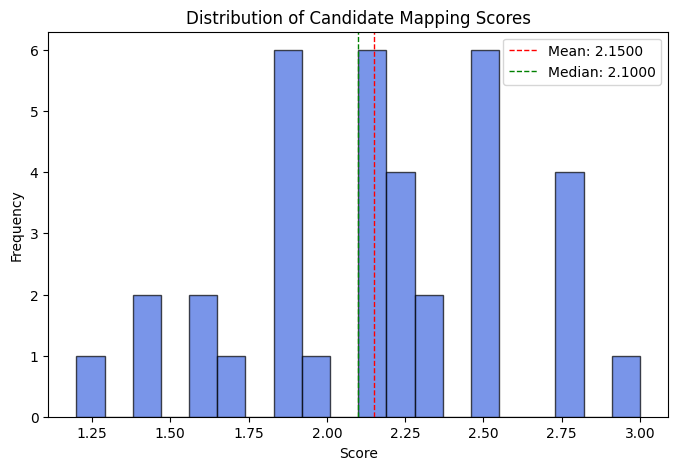

🔹 Total Candidates: 36
🔹 Mean Score: 2.1500
🔹 Median Score: 2.1000
🔹 Standard Deviation: 0.4178
🔹 Min Score: 1.2000, Max Score: 3.0000


In [8]:
import matplotlib.pyplot as plt
import numpy as np

# Compute scores for all valid candidates
ranked_candidates = rank_candidates(valid_candidates, source_nx_graph, target_nx_graph)

# Extract scores
scores = [score for _, score, _ in ranked_candidates]

# Compute statistics
mean_score = np.mean(scores)
median_score = np.median(scores)
std_dev = np.std(scores)

# Plot histogram
plt.figure(figsize=(8, 5))
plt.hist(scores, bins=20, color='royalblue', edgecolor='black', alpha=0.7)
plt.axvline(mean_score, color='red', linestyle='dashed', linewidth=1, label=f"Mean: {mean_score:.4f}")
plt.axvline(median_score, color='green', linestyle='dashed', linewidth=1, label=f"Median: {median_score:.4f}")
plt.title("Distribution of Candidate Mapping Scores")
plt.xlabel("Score")
plt.ylabel("Frequency")
plt.legend()
plt.show()

# Print statistics
print(f"🔹 Total Candidates: {len(scores)}")
print(f"🔹 Mean Score: {mean_score:.4f}")
print(f"🔹 Median Score: {median_score:.4f}")
print(f"🔹 Standard Deviation: {std_dev:.4f}")
print(f"🔹 Min Score: {min(scores):.4f}, Max Score: {max(scores):.4f}")


In [9]:
def find_correct_mapping(valid_candidates, expected_node_mapping, expected_edge_mapping):
    """
    Searches for the correct mapping in the list of valid candidates.

    Args:
        valid_candidates (list): List of valid candidate mappings.
        expected_node_mapping (dict): The correct node mapping.
        expected_edge_mapping (dict): The correct edge mapping.

    Returns:
        bool: True if the correct mapping is found, False otherwise.
    """
    print("\n🔍 Searching for the correct mapping in valid candidates...\n")
    found = False

    for idx, candidate in enumerate(valid_candidates):
        candidate_node_mapping = candidate["node_mapping"]
        candidate_edge_mapping = candidate["edge_mapping"]

        # Normalize candidate mappings for comparison
        norm_nodes = {str(k): str(v) for k, v in candidate_node_mapping.items()}

        # Normalize edge mappings, handling None values
        norm_edges = {}
        for k, v in candidate_edge_mapping.items():
            if v is None:
                norm_edges[(str(k[0]), k[1], str(k[2]))] = None
            else:
                norm_edges[(str(k[0]), k[1], str(k[2]))] = (str(v[0]), v[1], str(v[2]))

        # Normalize expected mappings for comparison
        norm_expected_nodes = {str(k): str(v) for k, v in expected_node_mapping.items()}
        norm_expected_edges = {(str(k[0]), k[1], str(k[2])): (str(v[0]), v[1], str(v[2])) for k, v in expected_edge_mapping.items()}

        if norm_nodes == norm_expected_nodes and norm_edges == norm_expected_edges:
            print(f"\n✅ Correct mapping found in candidate {idx + 1}:")
            print("Node Mapping:", candidate_node_mapping)
            print("Edge Mapping:", candidate_edge_mapping)
            found = True
            break

    if not found:
        print("\n❌ Correct mapping was NOT found in valid candidates.")

    return found


# Run the verification function
correct_mapping_found = find_correct_mapping(valid_candidates, expected_node_mapping, expected_edge_mapping)


🔍 Searching for the correct mapping in valid candidates...


✅ Correct mapping found in candidate 1:
Node Mapping: {rdflib.term.URIRef('tgt:Employee'): rdflib.term.URIRef('src:Person'), rdflib.term.URIRef('tgt:Company'): rdflib.term.URIRef('src:Organization'), rdflib.term.URIRef('tgt:Nation'): rdflib.term.URIRef('src:Country'), rdflib.term.URIRef('tgt:fullName'): rdflib.term.URIRef('src:name'), rdflib.term.URIRef('tgt:officeAddress'): rdflib.term.URIRef('src:address')}
Edge Mapping: {(rdflib.term.URIRef('tgt:Employee'), 'tgt:worksFor', rdflib.term.URIRef('tgt:Company')): (rdflib.term.URIRef('src:Person'), 'src:hasWorkedFor', rdflib.term.URIRef('src:Organization')), (rdflib.term.URIRef('tgt:Employee'), 'tgt:fullName', rdflib.term.URIRef('tgt:fullName')): (rdflib.term.URIRef('src:Person'), 'src:name', rdflib.term.URIRef('src:name')), (rdflib.term.URIRef('tgt:Company'), 'tgt:locatedIn', rdflib.term.URIRef('tgt:Nation')): (rdflib.term.URIRef('src:Organization'), 'src:locatedIn', rdflib.te

In [ ]:
if valid_candidates:
    selected_candidate = valid_candidates[0]  # choose the first valid candidate.
else:
    print("No valid candidate mapping available.")


In [19]:
selected_candidate

{'node_mapping': {rdflib.term.URIRef('tgt:Employee'): rdflib.term.URIRef('src:Person'),
  rdflib.term.URIRef('tgt:Company'): rdflib.term.URIRef('src:Organization'),
  rdflib.term.URIRef('tgt:Nation'): rdflib.term.URIRef('src:Country'),
  rdflib.term.URIRef('tgt:fullName'): rdflib.term.URIRef('src:name'),
  rdflib.term.URIRef('tgt:officeAddress'): rdflib.term.URIRef('src:address')},
 'edge_mapping': {(rdflib.term.URIRef('tgt:Employee'),
   'tgt:worksFor',
   rdflib.term.URIRef('tgt:Company')): (rdflib.term.URIRef('src:Person'),
   'src:hasWorkedFor',
   rdflib.term.URIRef('src:Organization')),
  (rdflib.term.URIRef('tgt:Employee'),
   'tgt:fullName',
   rdflib.term.URIRef('tgt:fullName')): (rdflib.term.URIRef('src:Person'),
   'src:name',
   rdflib.term.URIRef('src:name')),
  (rdflib.term.URIRef('tgt:Company'),
   'tgt:locatedIn',
   rdflib.term.URIRef('tgt:Nation')): (rdflib.term.URIRef('src:Organization'),
   'src:locatedIn',
   rdflib.term.URIRef('src:Country')),
  (rdflib.term.URIRe

In [61]:
from rdflib import URIRef

def extract_prefixes(rdf_graph):
    """Extract unique PREFIX declarations from an rdflib Graph."""
    prefix_dict = {p: ns for p, ns in rdf_graph.namespaces()}
    return "\n".join(f"PREFIX {p}: <{ns}>" for p, ns in sorted(prefix_dict.items()))

def build_tree(candidate):
    """Build a tree from candidate["edge_mapping"], mapping each target class to its child relationships."""
    tree = {}
    for (t_sub, t_pred, t_obj), _ in candidate["edge_mapping"].items():
        t_sub_str = str(t_sub)
        t_obj_str = str(t_obj)
        tree.setdefault(t_sub_str, []).append((t_pred, t_obj_str))
    return tree

def get_edge(candidate, parent, child):
    """Retrieve the source predicate that links `parent` to `child` from the candidate edge mapping."""
    for (t_sub, t_pred, t_obj), src_triple in candidate["edge_mapping"].items():
        if str(t_sub) == parent and str(t_obj) == child:
            return src_triple[1]  # Return the source predicate
    return None

def build_where_recursive(node, candidate, tree, source_ns, target_ns, target_nx_graph, 
                          iri_bind_statements, literal_bind_statements, parent_src_var=None, parent=None):
    """
    Recursively constructs WHERE clause patterns while collecting BIND statements separately.
    
    - Ensures proper ordering of `a` statements.
    - Ensures relationships (object properties) are linked before nesting properties.
    - Collects IRI-BIND statements in `iri_bind_statements`.
    - Collects literal BIND statements in `literal_bind_statements`.
    """
    lines = []
    node_str = str(node)
    node_uri = URIRef(node_str)

    if node_uri not in target_nx_graph:
        raise KeyError(f"Node {node_str} not found in target_nx_graph. Available nodes: {list(target_nx_graph.nodes)}")

    local = node_str.split(":")[-1]
    target_var = f"?{local}"
    
    # Look up source mapping
    src_mapping = candidate["node_mapping"].get(URIRef(node_str))
    if src_mapping is None:
        raise KeyError(f"No source mapping found for {node_str}. Candidate keys: {candidate['node_mapping'].keys()}")

    src_var = f"?{src_mapping.split(':')[-1]}"
    is_attr = target_nx_graph.nodes[node_uri].get("is_attribute", False)

    if not is_attr:
        # If this is a class node
        if parent_src_var is not None and parent is not None:
            edge = get_edge(candidate, parent, node_str)
            if edge:
                lines.append(f"  OPTIONAL {{")
                lines.append(f"    {parent_src_var} {edge} {src_var} .")

        # Declare type triple
        lines.append(f"    {src_var} a {src_mapping} .")

        # Collect IRI transformation BIND statement instead of placing it here
        iri_bind_statements.append(f'  BIND(IRI(CONCAT("{target_ns}", STRAFTER(STR({src_var}), "{source_ns}"))) AS {target_var})')

        # Process children recursively
        if node_str in tree:
            for rel, child in tree[node_str]:
                child_block = build_where_recursive(child, candidate, tree, source_ns, target_ns, 
                                                    target_nx_graph, iri_bind_statements, 
                                                    literal_bind_statements, parent_src_var=src_var, 
                                                    parent=node_str)
                if child_block.strip():
                    lines.append(child_block)  # Ensure proper nesting

        if parent_src_var is not None and parent is not None:
            lines.append(f"  }}")

    else:
        # If this is an attribute node, retrieve its literal from the parent
        if parent_src_var:
            lit_var = target_var + "_lit"
            lines.append(f"  OPTIONAL {{ {parent_src_var} {src_mapping} {lit_var} . }}")
            # Collect literal binding separately
            literal_bind_statements.append(f"  BIND({lit_var} AS {target_var})")

    return "\n".join(lines)

def generate_dynamic_construct_query_no_select(candidate, src_graph, tgt_graph, target_nx_graph):
    """
    Generates a SPARQL CONSTRUCT query without using SELECT, ensuring:
    
    - Proper ordering of `a` statements.
    - Correct nesting of OPTIONAL statements following the hierarchical structure.
    - Collecting all BIND statements at the end, with IRI-BINDs first.
    """
    SOURCE_NS = "http://example.org/src#"
    TARGET_NS = "http://example.org/tgt#"

    prefixes = extract_prefixes(src_graph) + "\n" + extract_prefixes(tgt_graph)

    tree = build_tree(candidate)

    all_nodes = set(str(n) for n in candidate["node_mapping"].keys())
    child_nodes = {child for children in tree.values() for _, child in children}
    roots = list(all_nodes - child_nodes)
    
    if not roots:
        raise ValueError("No root found in candidate mapping.")
    
    root = roots[0]  # Assume first root for simplicity

    # Collect BIND statements separately
    iri_bind_statements = []
    literal_bind_statements = []

    where_block = build_where_recursive(root, candidate, tree, SOURCE_NS, TARGET_NS, target_nx_graph, 
                                        iri_bind_statements, literal_bind_statements, parent_src_var=None, parent=None)

    # Append all IRI-BIND statements first, then literals
    bind_section = "\n".join(iri_bind_statements) + "\n" + "\n".join(literal_bind_statements)

    where_clause = "WHERE {\n" + where_block + "\n" + bind_section + "\n}"

    # Build CONSTRUCT clause
    construct_lines = []
    for t_node in candidate["node_mapping"]:
        t_str = str(t_node)
        node_uri = URIRef(t_str)
        if not target_nx_graph.nodes[node_uri].get("is_attribute", False):
            var = f"?{t_str.split(':')[-1]}"
            construct_lines.append(f"  {var} a {t_str} .")
    for (t_sub, t_pred, t_obj), _ in candidate["edge_mapping"].items():
        sub_str = str(t_sub)
        obj_str = str(t_obj)
        construct_lines.append(f"  ?{sub_str.split(':')[-1]} {t_pred} ?{obj_str.split(':')[-1]} .")
    construct_clause = "CONSTRUCT {\n" + "\n".join(construct_lines) + "\n}"

    query = prefixes + "\n" + construct_clause + "\n" + where_clause
    return query


In [62]:
from rdflib import Graph, Namespace

# Load the source data graph from your Turtle file.
src_data_graph = Graph()
src_data_graph.parse("src_graph_test.ttl", format="turtle")

# Assume you have already selected a candidate mapping and generated a dynamic CONSTRUCT query.
# For example, you might have:
selected_candidate = valid_candidates[0]
query_str = generate_dynamic_construct_query_no_select(selected_candidate, src_graph, tgt_graph, target_nx_graph)
# (query_str is the SPARQL CONSTRUCT query as a string.)

# For this example, let's assume query_str is already defined.
print("Generated CONSTRUCT Query:\n", query_str)

# Execute the CONSTRUCT query on the source data graph.
# The result of a CONSTRUCT query is a new graph.
result = src_data_graph.query(query_str)

# In rdflib, the result of a CONSTRUCT query is a SPARQLResult that has a .graph attribute.
# (In some versions you may need to build the graph by iterating over the result.)
try:
    tgt_data_graph = result.graph
except AttributeError:
    tgt_data_graph = Graph()
    for triple in result:
        tgt_data_graph.add(triple)

TGT = Namespace("http://example.org/tgt#")
tgt_data_graph.bind("tgt", TGT)
# Serialize the target graph to a Turtle file.
tgt_data_graph.serialize(destination="tgt_graph_test.ttl", format="turtle")
print("Target graph saved to 'tgt_graph_test.ttl' with", len(tgt_data_graph), "triples.")

Generated CONSTRUCT Query:
 PREFIX brick: <https://brickschema.org/schema/Brick#>
PREFIX csvw: <http://www.w3.org/ns/csvw#>
PREFIX dc: <http://purl.org/dc/elements/1.1/>
PREFIX dcam: <http://purl.org/dc/dcam/>
PREFIX dcat: <http://www.w3.org/ns/dcat#>
PREFIX dcmitype: <http://purl.org/dc/dcmitype/>
PREFIX dcterms: <http://purl.org/dc/terms/>
PREFIX doap: <http://usefulinc.com/ns/doap#>
PREFIX foaf: <http://xmlns.com/foaf/0.1/>
PREFIX geo: <http://www.opengis.net/ont/geosparql#>
PREFIX odrl: <http://www.w3.org/ns/odrl/2/>
PREFIX org: <http://www.w3.org/ns/org#>
PREFIX owl: <http://www.w3.org/2002/07/owl#>
PREFIX prof: <http://www.w3.org/ns/dx/prof/>
PREFIX prov: <http://www.w3.org/ns/prov#>
PREFIX qb: <http://purl.org/linked-data/cube#>
PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
PREFIX schema: <https://schema.org/>
PREFIX sh: <http://www.w3.org/ns/shacl#>
PREFIX skos: <http://www.w3.org/2004/02/skos/core#>
PREFIX sosa: 